In [1]:
import torch
import cv2
import torchvision
import os
import h5py
import numpy as np
import librosa
import time
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [31]:
def generate_spectrogram(audio):
    spectro = librosa.core.stft(audio, n_fft=512, hop_length=160, win_length=400, center=True)
    real = np.expand_dims(np.real(spectro), axis=0)
    imag = np.expand_dims(np.imag(spectro), axis=0)
    spectro_two_channel = np.concatenate((real, imag), axis=0)
    return spectro_two_channel

def audio_normalize(samples, desired_rms = 0.1, eps = 1e-4):
    rms = np.maximum(eps, np.sqrt(np.mean(samples**2)))
    samples = samples * (desired_rms / rms)
    return rms / desired_rms, samples

def mask_out(frame, col, row):
    frame = np.array(frame)
    x = 4*col
    y = 4*row
    frame[y:y+4, x:x+4, :] = 0
    return frame

def write_loss(loss_map, col, row, loss):
    x = 4*col
    y = 4*row
    loss_map[y:y+4, x:x+4] = loss
    return loss_map

In [32]:
data = {}
loss_map = np.zeros((128,156))
model = torch.load("trained_model/audio_dense_1.pth")

In [33]:
input_audio, sr = librosa.load("demo/visualize/000003.wav", mono=False, sr=16000)
audio_mix = input_audio[0] + input_audio[1]
audio_diff = input_audio[0] - input_audio[1]
data['audio_mix'] = torch.FloatTensor(generate_spectrogram(audio_mix)).unsqueeze(0)
data['audio_diff'] = torch.FloatTensor(generate_spectrogram(audio_diff)).unsqueeze(0)

In [34]:
input_image = Image.open("demo/visualize/000003.png")
input_image = input_image.resize((256,128))

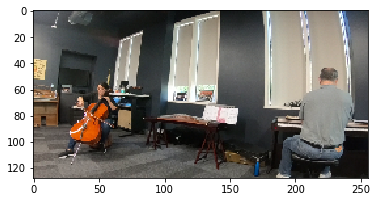

In [35]:
plt.imshow(input_image)

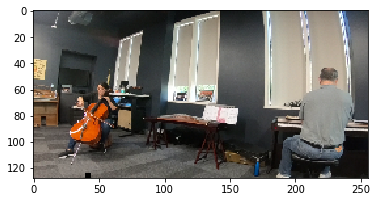

In [36]:
mask = mask_out(input_image, 10, 31)
mask = Image.fromarray(mask)
plt.imshow(mask)

## Main loop

In [37]:
for i in tqdm(range(32*64), ascii=True):
    col = int(i % 64)
    row = int(i / 64)
    mask_image = mask_out(input_image, col, row)
    mask_image = Image.fromarray(mask_image)
    mask_image = torchvision.transforms.ToTensor()(mask_image)
    data['frame'] = mask_image.unsqueeze(0)
    
    with torch.no_grad():
        out = model(data)

    loss_criterion = torch.nn.MSELoss()
    loss = loss_criterion(out, data['audio_diff'][:,:,:-1,:])

    loss_map = write_loss(loss_map, col, row, loss)

0%|          | 0/2048 [00:00<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [28]:
loss_map = np.loadtxt("loss_map.txt")

In [29]:
loss_map

array([[0.23035447, 0.23035447, 0.23035447, ..., 0.22984987, 0.22984987,
        0.22984987],
       [0.23035447, 0.23035447, 0.23035447, ..., 0.22984987, 0.22984987,
        0.22984987],
       [0.23035447, 0.23035447, 0.23035447, ..., 0.22984987, 0.22984987,
        0.22984987],
       ...,
       [0.23205741, 0.23205741, 0.23205741, ..., 0.23224294, 0.23224294,
        0.23224294],
       [0.23205741, 0.23205741, 0.23205741, ..., 0.23224294, 0.23224294,
        0.23224294],
       [0.23205741, 0.23205741, 0.23205741, ..., 0.23224294, 0.23224294,
        0.23224294]])

In [30]:
loss_map.min()

0.19189362227916718

In [24]:
loss_map = (loss_map - loss_map.min()) / (loss_map.max() - loss_map.min())

In [25]:
loss_map.mean()

0.5351920268922079

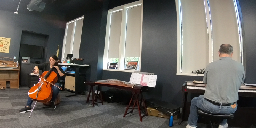

In [27]:
input_image = Image.open("demo/visualize/000003.png")
input_image = input_image.resize((256,128))
input_image

In [31]:
img = Image.fromarray(np.uint8(loss_map * 255))

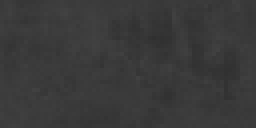

In [35]:
img

In [21]:
np.array(img).shape

(128, 156)

## Generate Heatmap

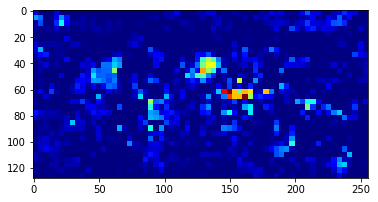

In [145]:
grayimg = Image.open("loss_map.png")
grayimg = np.array(grayimg)/255
# grayimg = 1 - grayimg
grayimg = np.uint8(grayimg * 255)
heatmap = cv2.applyColorMap(grayimg, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

In [63]:
cv2.imwrite("heatmap.jpg", cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))

True

In [120]:
heatmap.shape

(128, 256, 3)

In [ ]:
grayimg=np.uint16(grayimg)
for i in range(grayimg.shape[0]):
    for j in range(grayimg.shape[1]):
        grayimg[i,j] = grayimg[i,j] + 50
        if grayimg[i,j] > 255:
            grayimg[i,j]=255
grayimg=np.uint8(grayimg)

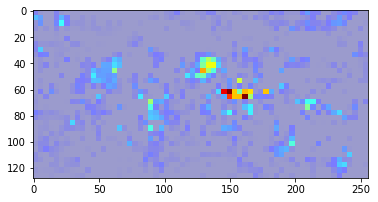

In [155]:
alpha = np.expand_dims(grayimg, 2)
rgba = np.concatenate((heatmap, alpha), axis=2)
plt.imshow(rgba)

In [156]:
cv2.imwrite("heatmap.png", cv2.cvtColor(rgba, cv2.COLOR_RGB2BGRA))

True

In [164]:
root_dir = "demo/visualize"
folders = os.listdir(root_dir)
img_dir = [os.path.join(root_dir, folder) for folder in folders]

for d in img_dir:
    grayimg = Image.open(os.path.join(d, "loss_map.png"))
    grayimg = np.array(grayimg)
    grayimg = np.uint16(grayimg)
    for i in range(grayimg.shape[0]):
        for j in range(grayimg.shape[1]):
            grayimg[i,j] = grayimg[i,j] + 50
            if grayimg[i,j] > 255:
                grayimg[i,j]=255
    grayimg=np.uint8(grayimg)

    heatmap = cv2.applyColorMap(grayimg, cv2.COLORMAP_JET)

    alpha = np.expand_dims(grayimg, 2)
    rgba = np.concatenate((heatmap, alpha), axis=2)

    cv2.imwrite(os.path.join(d, "heatmap.png"), rgba)

In [163]:
grayimg.min()

80